# Resnet
Flexible code using Resnet architecture that can be trained on different datasets

In [25]:
%pwd

In [20]:
import os, sys
import numpy as np
import importlib
import utils; importlib.reload(utils)
from utils import *

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
np.set_printoptions(suppress=True)

%matplotlib inline

AttributeError: 'NoneType' object has no attribute 'name'

In [3]:
#reference to imp directories
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/dogscats/'

In [4]:
path=DATA_HOME_DIR

In [5]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
models_path = DATA_HOME_DIR + 'models/resnet/'
test_path = DATA_HOME_DIR + '/test/' #Using all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/hearth/ML/course/deeplearning1/nbs/data/dogscats


In [6]:
batch_size = 64

In [7]:
def assign_batches(shuffle, batch_size, target_size):
    return (get_batches(train_path, batch_size=batch_size, shuffle=shuffle, target_size=target_size),
get_batches(valid_path, batch_size=batch_size, shuffle=shuffle, target_size=target_size),
get_batches(test_path, batch_size=batch_size, shuffle=shuffle, target_size=target_size))

In [8]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

shuffle is  False
Found 22998 images belonging to 2 classes.
shuffle is  False
Found 2000 images belonging to 2 classes.
shuffle is  False
Found 12500 images belonging to 1 classes.


## Resnet
Resnet is unique in that it is made of Resnet blocks where, in each block there is conv layers in succession but in the end of a resnet block, there is an addition with an identity matrix. Maxpooling is done after this to conform with matrix dimension requirements. 



In [9]:
LESSON_HOME_DIR

'/home/hearth/ML/course/deeplearning1/nbs'

In [10]:
%cd $LESSON_HOME_DIR
import resnet50; importlib.reload(resnet50)
from resnet50 import Resnet50
%cd $DATA_HOME_DIR

/home/hearth/ML/course/deeplearning1/nbs
/home/hearth/ML/course/deeplearning1/nbs/data/dogscats


In [11]:
rn0 = Resnet50(include_top=False, size=(400,400)).model
rn0.output_shape[1:]

/opt/anaconda/lib/python3.6/site-packages/keras/layers/core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/home/hearth/ML/course/deeplearning1/nbs/resnet50.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
  x = Conv2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)  # Keras2


here I go again


(2048, 13, 13)

In [12]:
batches, val_batches, test_batches = assign_batches(shuffle=False, 
                                        batch_size=batch_size, target_size=(400,400))

shuffle is  False
Found 22998 images belonging to 2 classes.
shuffle is  False
Found 2000 images belonging to 2 classes.
shuffle is  False
Found 12500 images belonging to 1 classes.


### Resnet on smaller images

In [16]:
#Setting include top to false means only include convolutional layers and
#the additional fully connected blocks will be ignored. 
rn0 = Resnet50(include_top=False).model

/opt/anaconda/lib/python3.6/site-packages/keras/layers/core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/home/hearth/ML/course/deeplearning1/nbs/resnet50.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
  x = Conv2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)  # Keras2


here I go again


In [17]:
rn0.output_shape[1:]

(2048, 7, 7)

In [18]:
batches, val_batches, test_batches = assign_batches(shuffle=False, 
                                        batch_size=batch_size, target_size=(224,224))

shuffle is  False
Found 22998 images belonging to 2 classes.
shuffle is  False
Found 2000 images belonging to 2 classes.
shuffle is  False
Found 12500 images belonging to 1 classes.


#### If RAM>32

In [ ]:
val_features = rn0.predict_generator(val_batches, np.ceil(val_batches.samples/batch_size))

In [ ]:
trn_features = rn0.predict_generator(batches, np.ceil(batches.samples/batch_size))

In [ ]:
trn_labels[0]

In [ ]:
trn_features= load_array(models_path + 'trn_rn0_conv.bc')
val_features = load_array(models_path +'val_rn0_conv.bc')

### Precompute features

[Optional] Clean existing saved convolution features if required

In [21]:
%cd $models_path
%rm -R *.dat
%cd $DATA_HOME_DIR

/home/hearth/ML/course/deeplearning1/nbs/data/dogscats/models/resnet
/home/hearth/ML/course/deeplearning1/nbs/data/dogscats


#### If RAM<32

In [ ]:
fname = models_path+'trn_rn0_conv.dat'
for i in range(batches.n // batch_size+1):
    conv_feat = rn0.predict_on_batch(batches.next()[0])
    if not i:
        c = bcolz.carray(conv_feat, rootdir=fname, mode='a')
    else:
        c.append(conv_feat)
    c.shape
c.flush()

In [ ]:
fname = models_path+'val_rn0_conv.dat'
for i in range(val_batches.n // batch_size+1):
    conv_val_feat = rn0.predict_on_batch(val_batches.next()[0])
    if not i:
        c = bcolz.carray(conv_val_feat, rootdir=fname, mode='a')
    else:
        c.append(conv_val_feat)
c.flush()

In [ ]:
fname = models_path+'val_rn0_conv_y.dat'
save_array(fname, val_labels)
fname = models_path+'trn_rn0_conv_y.dat'
save_array(fname, trn_labels)

In [13]:
X=bcolz.open(models_path+'trn_rn0_conv.dat', mode='r')
y= bcolz.open(models_path+'trn_rn0_conv_y.dat', mode='r')

In [14]:
valX=bcolz.open(models_path+'val_rn0_conv.dat', mode='r')
valy= bcolz.open(models_path+'val_rn0_conv_y.dat', mode='r')

In [15]:
trn_batches=BcolzArrayIterator(X,y, batch_size=batch_size, shuffle=True)
val_batches=BcolzArrayIterator(valX,valy, batch_size=batch_size, shuffle=True)

## Fully connected layer

In [ ]:
trn_batches.N

In [ ]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1, input_shape=rn0.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [ ]:
fc_model = Sequential(get_fc_layers(0.8))
fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fc_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fc_model.fit_generator(trn_batches, epochs=5, steps_per_epoch=np.ceil(trn_batches.N/batch_size), validation_data=val_batches, 
                     validation_steps=int(np.ceil(val_batches.N/batch_size)))

In [ ]:
fc_model.fit(trn_features, trn_labels, epochs=5, batch_size=batch_size, validation_data=(val_features, val_labels))

## Global Average Pooling Layer

It takes in as output the 2048 13x13 (dogs-cats) output of convolution layers and does average pooling on all of them essentially putting a single number on all features which represents a feature corresponding to a label. eg: a feature map learning to see cat tails will respond with a higher number to a cat and make for a good input to final Dense layer. 

Advantages:
1. No dropouts because very minimal dense layers - Also generalise better because lot less 
parameters.
2. Average pooling might work better in a usecases like cats and dogs where subject spans the whole image. 
3. Resnet used average pooling in its original version and it makes sense to leverage the benefits provided by the weights trained on a dataset with average pooling switched on.

In [16]:
 def get_ap_layers(p):
        return [
            GlobalAveragePooling2D(input_shape=rn0.output_shape[1:]),
            Dropout(p),
            Dense(2, activation='softmax')
        ]

In [17]:
model = Sequential(get_ap_layers(0.01))

In [18]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(trn_batches, epochs=5, steps_per_epoch=np.ceil(trn_batches.N/batch_size), validation_data=val_batches, 
                     validation_steps=int(np.ceil(val_batches.N/batch_size)))

Epoch 1/5
360/360 [==============================] - 75s - loss: 0.0792 - acc: 0.9740 - val_loss: 0.0447 - val_acc: 0.9850
Epoch 2/5
360/360 [==============================] - 16s - loss: 0.0308 - acc: 0.9896 - val_loss: 0.0313 - val_acc: 0.9890
Epoch 3/5
360/360 [==============================] - 16s - loss: 0.0249 - acc: 0.9918 - val_loss: 0.0298 - val_acc: 0.9900
Epoch 4/5
360/360 [==============================] - 16s - loss: 0.0214 - acc: 0.9931 - val_loss: 0.0273 - val_acc: 0.9910
Epoch 5/5
360/360 [==============================] - 16s - loss: 0.0189 - acc: 0.9937 - val_loss: 0.0260 - val_acc: 0.9915


## Making predictions on individual samples

In [35]:
def predict_on_single(img):
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    img = scipy.misc.imresize(img, (400, 400))
    img = img.reshape([1, 3, 400, 400], order='C')
    conv_feat = rn0.predict(img)
    prob = model.predict(conv_feat, batch_size=None, verbose=0)
    return (prob)

(190, 200, 3)


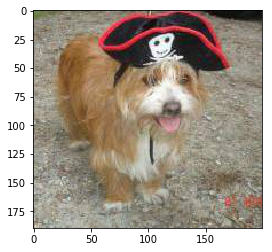

array([[ 0.0237,  0.9763]], dtype=float32)

In [41]:
img = mpimg.imread(path+'/dog.1.jpg')
predict_on_single(img)